In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from scipy import integrate

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import functools
import os
import math
import functools
import string
import wandb
from tqdm import tqdm


import sys
from utils import Config

 
 ##Main functions

In [2]:
def loss_pfgm(model, batch, labels=None, uncond_prob=0.1):
    """Compute the loss function with conditional target calculation.

    For labels without corresponding data, falls back to unconditional E function.
    """
    samples_full = batch
    samples_batch = batch[: sde.config.training.small_batch_size]

    m = torch.rand((samples_batch.shape[0],), device=samples_batch.device) * sde.M
    perturbed_samples_vec = forward_pz(sde, sde.config, samples_batch, m)

    # Process labels for conditional generation
    if labels is not None:
        # Apply unconditional probability mask
        mask = np.random.choice(np.arange(2), replace=True, size=samples_batch.shape[0], p=[1 - uncond_prob, uncond_prob]).astype(bool)
        batch_labels = labels[:samples_batch.shape[0]].clone()
        batch_labels[mask] = 10  # Set masked samples to unconditional
        # Convert to one-hot encoding for model input
        labels_onehot = (batch_labels[:, None] == torch.arange(11, device=labels.device)[None, :]).float()
        full_labels = labels
    else:
        # If no labels provided, treat all as unconditional
        batch_labels = torch.full((samples_batch.shape[0],), 10, device=samples_batch.device)
        full_labels = torch.full((samples_full.shape[0],), 10, device=samples_full.device)
        labels_onehot = torch.zeros((samples_batch.shape[0], 11), device=samples_batch.device)
        labels_onehot[:, 10] = 1.0

    with torch.no_grad():
        real_samples_vec = torch.cat(
          (samples_full.reshape(len(samples_full), -1),
           torch.zeros((len(samples_full), 1)).to(samples_full.device)), dim=1)

        data_dim = sde.config.data.image_size * sde.config.data.image_size * sde.config.data.channels

        # Get unconditional samples (for fallback)
        uncond_samples = real_samples_vec

        # Initialize target tensor
        target = torch.zeros_like(perturbed_samples_vec)

        # Calculate target for each label group separately
        for label_idx in range(11):
            # Get indices of samples with current label in the small batch
            batch_mask = (batch_labels == label_idx)

            # Skip if no samples with this label in the small batch
            if not torch.any(batch_mask):
                continue

            # Select real samples based on label
            if label_idx == 10:  # Unconditional - use all samples
                filtered_real = uncond_samples
            else:
                # For conditional, use only samples with matching label
                full_mask = (full_labels == label_idx)

                # If no matching samples in full batch, fall back to unconditional
                if not torch.any(full_mask):
                    filtered_real = uncond_samples
                else:
                    filtered_real = real_samples_vec[full_mask]

            # Get current perturbed samples
            curr_perturbed = perturbed_samples_vec[batch_mask]

            # Calculate distances
            distances = torch.sum((curr_perturbed.unsqueeze(1) - filtered_real) ** 2, dim=-1).sqrt()

            # For numerical stability
            min_dist, _ = torch.min(distances, dim=1, keepdim=True)
            distances = min_dist / (distances + 1e-7)
            distances = distances ** (data_dim + 1)

            # Normalize coefficients
            coeff = distances / (torch.sum(distances, dim=1, keepdim=True) + 1e-7)

            # Calculate direction
            diff = -(curr_perturbed.unsqueeze(1) - filtered_real)

            # Calculate Poisson field
            gt_direction = torch.sum(coeff.unsqueeze(-1) * diff, dim=1)

            # Normalize
            gt_norm = gt_direction.norm(p=2, dim=1, keepdim=True)
            gt_direction = gt_direction / (gt_norm + sde.config.training.gamma)
            gt_direction = gt_direction * np.sqrt(data_dim)

            # Assign to target
            target[batch_mask] = gt_direction

    perturbed_samples_x = perturbed_samples_vec[:, :-1].view_as(samples_batch)
    perturbed_samples_z = torch.clamp(perturbed_samples_vec[:, -1], 1e-10)

    # Pass the one-hot encoded labels to the model
    net_x, net_z = model(perturbed_samples_x, perturbed_samples_z * torch.ones(samples_batch.shape[0], device='cuda'), labels_onehot)

    net_x = net_x.view(net_x.shape[0], -1)
    net = torch.cat([net_x, net_z[:, None]], dim=1)
    loss = ((net - target) ** 2)
    loss = torch.mean(loss)

    return loss

In [3]:
def forward_pz(sde, config, samples_batch, m):

    """Perturbing the augmented training data. See Algorithm 2 in PFGM paper.

    Args:
      sde: An `methods.SDE` object that represents the forward SDE.
      config: configurations
      samples_batch: A mini-batch of un-augmented training data
      m: A 1D torch tensor. The exponents of (1+\tau).

    Returns:
      Perturbed samples
    """

    data_dim = config.data.channels * config.data.image_size * config.data.image_size # N
    tau = config.training.tau
    z = torch.randn((len(samples_batch), 1, 1, 1)).to(samples_batch.device) * config.model.sigma_end  # [B,1,1,1]
    z = z.abs() # [B,1,1,1]


    # Confine the norms of perturbed data.
    # see Appendix B.1.1 of https://arxiv.org/abs/2209.11178
    if config.training.restrict_M:
        idx = (z < 0.005).squeeze()
        num = int(idx.int().sum())
        restrict_m = int(sde.M * 0.7)
        m[idx] = torch.rand((num,), device=samples_batch.device) * restrict_m


    multiplier = (1+tau) ** m # torch.Size([B])
    # Perturb z
    perturbed_z = z.squeeze() * multiplier # torch.Size([B])* torch.Size([B]) = torch.Size([B])


    ####### perturbation for x component #######

    # Sample uniform angle
    gaussian = torch.randn(len(samples_batch), data_dim).to(samples_batch.device) # torch.Size([B, C*H*W])
    unit_gaussian = gaussian / torch.norm(gaussian, p=2, dim=1, keepdim=True) #  torch.Size([B, C*H*W])

    # injected noise amount
    noise = torch.randn_like(samples_batch).reshape(len(samples_batch), -1) * config.model.sigma_end #torch.Size([B, C*H*W])
    norm_m = torch.norm(noise, p=2, dim=1) * multiplier # torch.Size([B])*torch.Size([B]) = torch.Size([B])


    # Construct the perturbation for x
    perturbation_x = unit_gaussian * norm_m[:, None] # torch.Size([B,C*H*W])* torch.Size([B,1])=  torch.Size([B,C*H*W])
    perturbation_x = perturbation_x.view_as(samples_batch) # torch.size([B,C,H,W])

    # Perturb x
    perturbed_x = samples_batch + perturbation_x # torch.size([B,C,H,W])

    # Augment the data with extra dimension z
    perturbed_samples_vec = torch.cat((perturbed_x.reshape(len(samples_batch), -1),
                                       perturbed_z[:, None]), dim=1)

    # concatenate: torch.Size([B,C*H*W], torch.Size([[B,1]]) = torch.Size([B,C*H*W + 1]
    return perturbed_samples_vec

In [4]:
class Poisson():


    def __init__(self, config):
        """Construct a PFGM.

        Args:
          config: configurations
        """
        self.config = config
        self.N = config.sampling.N


    @property
    def M(self):
        return self.config.training.M


    def prior_sampling(self, shape):
        """
        Sampling initial data from p_prior on z=z_max hyperplane.
        See Section 3.3 in PFGM paper
        returns - torch.Size([B,C,H,W])
        """

        # Sample the radius from p_radius (details in Appendix A.4 in the PFGM paper)
        max_z = self.config.sampling.z_max
        N = self.config.data.channels * self.config.data.image_size * self.config.data.image_size + 1

        # Sampling form inverse-beta distribution
        samples_norm = np.random.beta(a=N / 2. - 0.5, b=0.5, size=shape[0])
        inverse_beta = samples_norm / (1 - samples_norm)

        # Sampling from p_radius(R) by change-of-variable
        samples_norm = np.sqrt(max_z ** 2 * inverse_beta)

        # clip the sample norm (radius)
        samples_norm = np.clip(samples_norm, 1, self.config.sampling.upper_norm)
        samples_norm = torch.from_numpy(samples_norm).cuda().view(len(samples_norm), -1)

        # Uniformly sample the angle direction
        gaussian = torch.randn(shape[0], N - 1).cuda()
        unit_gaussian = gaussian / torch.norm(gaussian, p=2, dim=1, keepdim=True)

        # Radius times the angle direction
        init_samples = unit_gaussian * samples_norm

        return init_samples.float().view(len(init_samples), self.config.data.num_channels,
                                    self.config.data.image_size, self.config.data.image_size)




    def ode(self, net_fn, x, t, class_labels, cfg = 0.0):

        z = np.exp(t.mean().cpu())
        if self.config.sampling.vs:
            print(z)
        x_drift_cond, z_drift_cond = net_fn(x, torch.ones((len(x))).cuda() * z, class_labels)

        uncond_labels = torch.zeros_like(class_labels)
        uncond_labels[:, -1] = 1.0



        x_drift_uncond, z_drift_uncond = net_fn(x, torch.ones((len(x))).cuda() * z, uncond_labels)
        x_drift =  x_drift_uncond + cfg * x_drift_cond
        z_drift =  z_drift_uncond + cfg * z_drift_cond
        x_drift = x_drift.view(len(x_drift), -1)

        # Substitute the predicted z with the ground-truth
        # Please see Appendix B.2.3 in PFGM paper (https://arxiv.org/abs/2209.11178) for details
        z_exp = self.config.sampling.z_exp
        if z < z_exp and self.config.training.gamma > 0:
            data_dim = self.config.data.image_size * self.config.data.image_size * self.config.data.channels
            sqrt_dim = np.sqrt(data_dim)
            norm_1 = x_drift.norm(p=2, dim=1) / sqrt_dim
            x_norm = self.config.training.gamma * norm_1 / (1 -norm_1)
            x_norm = torch.sqrt(x_norm ** 2 + z ** 2)
            z_drift = -sqrt_dim * torch.ones_like(z_drift) * z / (x_norm + self.config.training.gamma)

        # Predicted normalized Poisson field
        v = torch.cat([x_drift, z_drift[:, None]], dim=1)

        dt_dz = 1 / (v[:, -1] + 1e-5)
        dx_dt = v[:, :-1].view(len(x), self.config.data.num_channels,
                          self.config.data.image_size, self.config.data.image_size)
        dx_dz = dx_dt * dt_dz.view(-1, *([1] * len(x.size()[1:])))
        # dx/dt_prime =  z * dx/dz
        dx_dt_prime = z * dx_dz
        return dx_dt_prime

In [ ]:
def get_euler_sampler_pfgm(sde, shape, num_steps=1000, eps=1e-3, device='cuda'):
    """
    Euler ODE sampler for PFGM.

    Args:
        sde: An methods.SDE object that represents PFGM.
        shape: A sequence of integers. The expected shape of a single sample.
        num_steps: Integer, number of Euler steps.
        eps: Float, final integration time (in log space).
        device: PyTorch device.

    Returns:
        A sampling function that returns samples and number of function evaluations (nfe).
    """

    def euler_sampler(model, x=None, class_labels=None, cfg=0.0):
        with torch.no_grad():
            if x is None:
                x = sde.prior_sampling(shape).to(device)
                z = torch.ones((len(x), 1, 1, 1)).to(x.device)
                z = z.repeat((1, 1, sde.config.data.image_size,
                              sde.config.data.image_size)) * sde.config.sampling.z_max
                x = x.view(shape)
                x = torch.cat((x, z), dim=1).float()

            new_shape = (len(x), sde.config.data.channels + 1,
                         sde.config.data.image_size, sde.config.data.image_size)

            t_start = np.log(sde.config.sampling.z_max)
            t_end = np.log(eps)
            dt = (t_end - t_start) / num_steps
            t = t_start

            x = x.clone()

            def ode_func(t, x):
                x = from_flattened_numpy(x, new_shape).to(device).type(torch.float32)
                z = np.exp(t)

                x_drift_cond, z_drift_cond = model(x[:, :-1],
                                                   torch.ones((len(x))).to(device) * z,
                                                   class_labels)

                uncond_labels = torch.zeros_like(class_labels)
                uncond_labels[:, -1] = 1.0


                x_drift_uncond, z_drift_uncond = model(x[:, :-1],
                                                       torch.ones((len(x))).to(device) * z,
                                                       uncond_labels)

                x_drift = x_drift_uncond + cfg * (x_drift_cond - x_drift_uncond)
                z_drift = z_drift_uncond + cfg * (z_drift_cond - z_drift_uncond)
                x_drift = x_drift.view(len(x_drift), -1)

                z_exp = sde.config.sampling.z_exp

                if z < z_exp and sde.config.training.gamma > 0:
                    data_dim = sde.config.data.image_size * sde.config.data.image_size * sde.config.data.channels
                    sqrt_dim = np.sqrt(data_dim)
                    norm_1 = x_drift.norm(p=2, dim=1) / sqrt_dim
                    x_norm = sde.config.training.gamma * norm_1 / (1 - norm_1)
                    x_norm = torch.sqrt(x_norm ** 2 + z ** 2)
                    z_drift = -sqrt_dim * torch.ones_like(z_drift) * z / (x_norm + sde.config.training.gamma)

                v = torch.cat([x_drift, z_drift[:, None]], dim=1)
                dt_dz = 1 / (v[:, -1] + 1e-7)
                dx_dt = v[:, :-1].view(shape)
                dx_dz = dx_dt * dt_dz.view(-1, *([1] * len(x.size()[1:])))
                drift = torch.cat([z * dx_dz,
                                   torch.ones((len(dx_dz), 1, sde.config.data.image_size,
                                               sde.config.data.image_size)).to(dx_dz.device) * z], dim=1)

                return to_flattened_numpy(drift)

            # Flatten x for integration
            x_flat = to_flattened_numpy(x)

            for _ in range(num_steps):
                dx = ode_func(t, x_flat)
                x_flat = x_flat + dt * dx
                t += dt

            x = torch.tensor(x_flat).reshape(new_shape).to(device).type(torch.float32)
            x = x[:, :-1]  # Remove z dimension

            return x, num_steps  # num_steps = nfe

    return euler_sampler

## Training and Results of generation 

In [6]:
config = Config()

config.device = 'cuda'

config.sampling = Config()
config.sampling.method = 'ode'
config.sampling.ode_solver = 'rk45'
config.sampling.N = 100
config.sampling.z_max = 40
config.sampling.z_min = 1e-3
config.sampling.upper_norm = 3000
config.sampling.z_exp=1
# verbose
config.sampling.vs = False


config.data = Config()
config.data.num_channels = 3
config.data.channels = 3
config.data.centered = True
config.data.img_resize = 16
config.data.image_size = 16




config.training = Config()
config.training.sde = 'poisson'
config.training.continuous = True
config.training.batch_size = 64#4096
config.training.small_batch_size = 64
config.training.gamma = 5
config.training.restrict_M = True
config.training.tau = 0.03
config.training.snapshot_freq = 1_000
config.training.eval_freq = 1_000
config.training.model = 'ddpmpp'
config.training.M = 291
config.training.reduce_mean = False
config.training.n_iters =  1_000_000


config.model  = Config()

config.model.name = 'ncsnpp'
config.model.scale_by_sigma = False
config.model.ema_rate = 0.9999
config.model.normalization = 'GroupNorm'
config.model.nonlinearity = 'swish'
config.model.nf = 128
config.model.ch_mult = (1, 2, 2, 2)
config.model.num_res_blocks = 4
config.model.attn_resolutions = (16,)
config.model.resamp_with_conv = True
config.model.conditional = True
config.model.fir = False
config.model.fir_kernel = [1, 3, 3, 1]
config.model.skip_rescale = True
config.model.resblock_type = 'biggan'
config.model.progressive = 'none'
config.model.progressive_input = 'none'
config.model.progressive_combine = 'sum'
config.model.attention_type = 'ddpm'
config.model.init_scale = 0.
config.model.fourier_scale = 16
config.model.embedding_type = 'positional'
config.model.conv_size = 3
config.model.sigma_end = 0.01
config.model.dropout = 0.1

config.optim  = Config()
config.optim.weight_decay = 0
config.optim.optimizer = 'Adam'
config.optim.lr = 2e-4
config.optim.beta1 = 0.9
config.optim.eps = 1e-8
config.optim.warmup = 5000
config.optim.grad_clip = 1.

### 8.2. Data

In [8]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [ ]:

from torchvision.transforms import Compose, CenterCrop, Resize


transform = Compose([
    CenterCrop(20),  # Center-crop to 20x20
    Resize(16),      # Resize to 16x16 (better than default 28→16)
    ToTensor(),
    torchvision.transforms.Normalize([0.5],[0.5])
])

train_data = ColoredMNIST(root='.', train=True, download=True, transform=transform)
#data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
eval_data = ColoredMNIST(root='.', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=config.training.batch_size, shuffle=True)
eval_loader =  torch.utils.data.DataLoader(eval_data, batch_size=config.training.batch_size, shuffle=True)

train_iter = iter(train_loader)
eval_iter = iter(eval_loader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.82MB/s]


### 8.3 Optimization and training

In [10]:



def optimization_manager(config):
    """Returns an optimize_fn based on `config`."""

    def optimize_fn(optimizer, params, step, lr=config.optim.lr,
                      warmup=config.optim.warmup,
                      grad_clip=config.optim.grad_clip):
        """Optimizes with warmup and gradient clipping (disabled if negative)."""
        if warmup > 0:
            for g in optimizer.param_groups:
                g['lr'] = lr * np.minimum(step / warmup, 1.0)
        if grad_clip >= 0:
            torch.nn.utils.clip_grad_norm_(params, max_norm=grad_clip)
        optimizer.step()

    return optimize_fn

In [ ]:
# !git clone https://github.com/NVlabs/edm/ edm
# %cd edm

# from training.networks import SongUNet, DhariwalUNet

In [15]:
# sys.path.append("/trinity/home/a.kolesov/ElectroBridge/")
# from models import DDPM, ExponentialMovingAverage
# from ddpm import DDPM
from models import ExponentialMovingAverage
from networks import DhariwalUNet
# net = DDPM(config).to(config.device)

net = DhariwalUNet(
    img_resolution=16,
    in_channels=3,
    out_channels=3,
    model_channels=64,
    channel_mult=[1, 2, 3, 4],
    num_blocks = 5,
    label_dim=11
).to(config.device)

params = net.parameters()
optimizer = torch.optim.Adam(params,
                       lr=config.optim.lr/2, betas=(config.optim.beta1, 0.999), eps=config.optim.eps,
                       weight_decay=config.optim.weight_decay)

ema = ExponentialMovingAverage(net.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=net, ema=ema, step=0)
sde = Poisson(config=config)
sampling_eps = config.sampling.z_min
optimize_fn = optimization_manager(config)
reduce_mean = config.training.reduce_mean

num_train_steps = config.training.n_iters

print(f"Модель имеет {sum(p.numel() for p in net.parameters())} параметров")

Модель имеет 43302084 параметров


In [78]:
net = torch.load('/content/cond_net_55', map_location="cuda", weights_only=False)


In [40]:
wandb.init(project="pfgm_16x16", name="Generation_conditional")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alzayts to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:

def plot(x):
    fig,ax = plt.subplots(5,5,figsize=(5,5))
    for idx in range(5):
        for jdx in range(5):
            ax[idx,jdx].imshow(x[idx,jdx])
            ax[idx,jdx].set_yticks([])
            ax[idx,jdx].set_xticks([])
    fig.tight_layout(pad=0.001)
    return fig


def to_flattened_numpy(x):
    """Flatten a torch tensor `x` and convert it to numpy."""
    return x.detach().cpu().numpy().reshape((-1,))


def from_flattened_numpy(x, shape):
    """Form a torch tensor with the given `shape` from a flattened numpy array `x`."""
    return torch.from_numpy(x.reshape(shape))

In [76]:
from tqdm.notebook import tqdm


  0%|          | 0/950664 [00:00<?, ?it/s]

  0%|          | 0/950664 [00:00<?, ?it/s]

Sample: -1.0145708322525024, 1.010249137878418, batch: -1.0, 1.0 
Sample: -1.0115952491760254, 1.0052059888839722, batch: -1.0, 1.0 
Sample: -1.018555998802185, 1.0124977827072144, batch: -1.0, 1.0 
Sample: -1.0304553508758545, 1.011316180229187, batch: -1.0, 1.0 
Sample: -0.996834397315979, 1.0097932815551758, batch: -1.0, 1.0 


KeyboardInterrupt: 

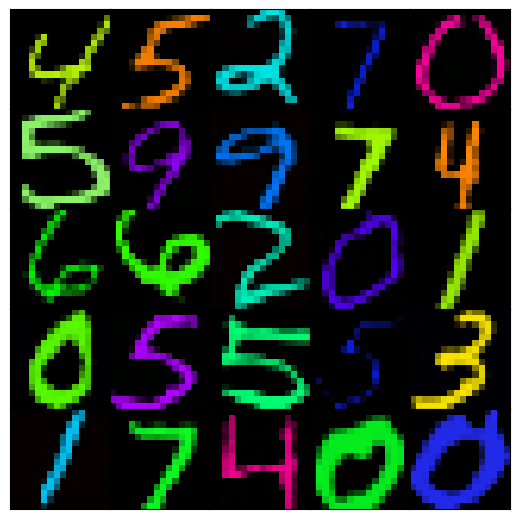

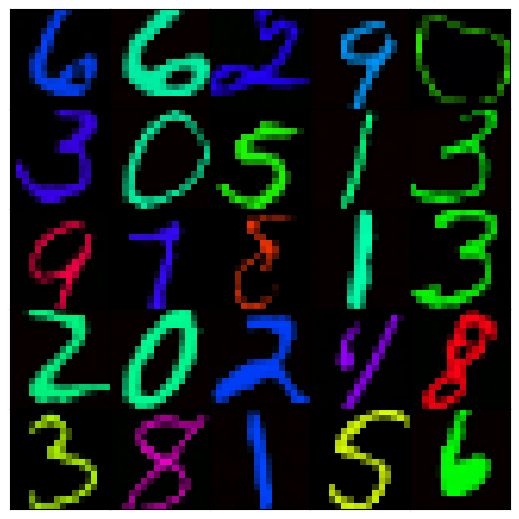

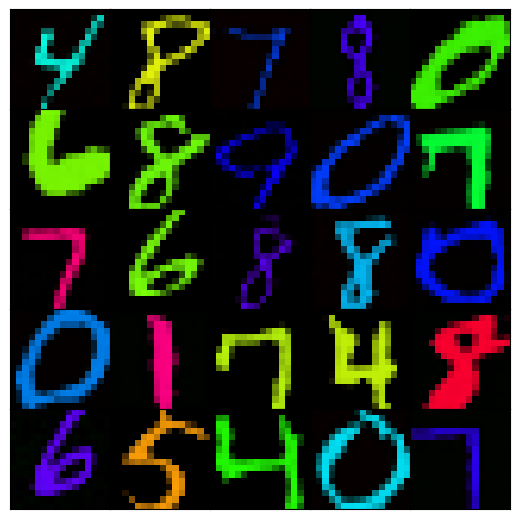

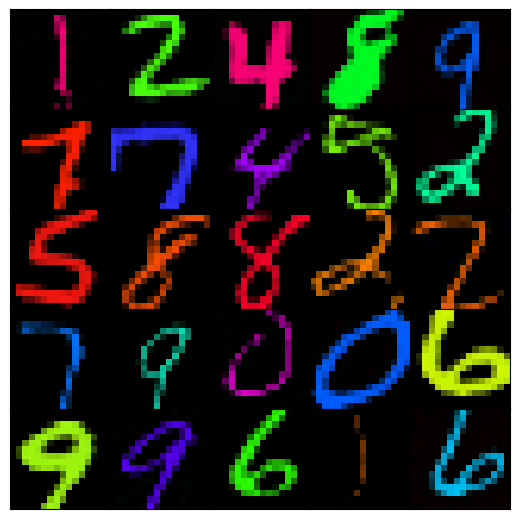

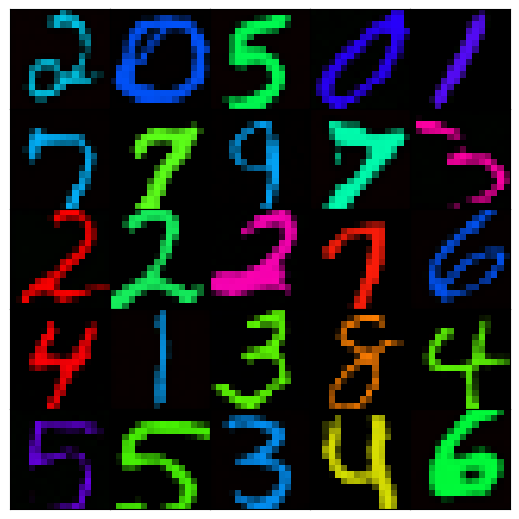

In [77]:
initial_step = 9537 + 2111 + 8377 + 431 + 6663 + 22218
cfg = 1
for step in tqdm(range(initial_step, num_train_steps + 1)):
    try:
        batch , labels =  next(train_iter)
    except StopIteration:
        print('stop')
    else:
        train_iter = iter(train_loader)
        batch, labels =  next(train_iter)
    # labels = (labels[:, None] == torch.arange(11, device=labels.device)[None, :]).float()

    labels = labels.to(config.device)
    batch = batch.to(config.device)

    optimizer = state['optimizer']
    optimizer.zero_grad()

    loss = loss_pfgm(net, batch, labels)
    loss.backward()
    optimize_fn(optimizer, net.parameters(), step=state['step'])
    state['step'] += 1
    state['ema'].update(net.parameters())
    wandb.log({"loss train":loss.item()},step=step)


    if step % config.training.eval_freq == 0:
        try:
            batch, labels = next(eval_iter)
            batch = batch.to(config.device)
            # labels = (labels[:, None] == torch.arange(11, device=labels.device)[None, :]).float()

            labels = labels.to(config.device)
        except StopIteration:
            print('Stop')
        else:
            eval_iter = iter(eval_loader)
            batch, labels = next(eval_iter)
            batch = batch.to(config.device)
            # labels = (labels[:, None] == torch.arange(11, device=labels.device)[None, :]).float()

            labels = labels.to(config.device)
        with torch.no_grad():
            ema = state['ema']
            ema.store(net.parameters())
            ema.copy_to(net.parameters())
            eval_loss = loss_pfgm(net, batch, labels)
            ema.restore(net.parameters())
            wandb.log({"loss eval":eval_loss.item()},step=step)



    if step % config.training.snapshot_freq == 0:
        ema.store(net.parameters())
        ema.copy_to(net.parameters())
        shape = (25, config.data.num_channels,
                      config.data.image_size, config.data.image_size)

        labels = torch.zeros(25, 11).cuda()
        idxs = np.random.randint(low=0, high=10, size=25)
        labels[np.arange(25), idxs] = 1



        # sampling_fn = get_rk45_sampler_pfgm(sde=sde,
        #                                    shape=shape,
        #                                    eps=config.sampling.z_min,
        #                                    device=config.device)
        sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cuda')
        sample, n = sampling_fn(net, class_labels = labels, cfg = cfg)
        ema.restore(net.parameters())
        print(f'Sample: {sample.min()}, {sample.max()}, batch: {batch.min()}, {batch.max()} ')


        sample = np.clip(sample.permute(0, 2, 3, 1).cpu().numpy() * 255, 0, 255).astype(np.uint8)
        fig = plot(sample.reshape(5,5,16,16,3))
        # fig = plot(sample.reshape(2,5,16,16,3))
        torch.save(net, f'cond_net_{step//1000 + 1}')

        wandb.log({"Generated Images":fig},step=step)

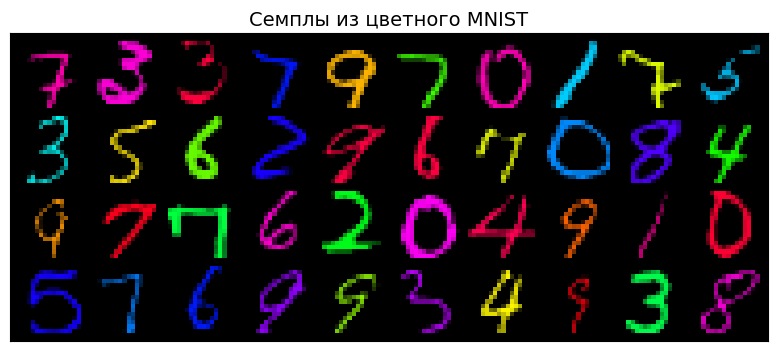

In [96]:
def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()

visualize_batch(next(iter(train_loader))[0][:40])

In [19]:
import os, shutil
from tqdm import tqdm
from PIL import Image


# сохраним семплы из модели для дальнейшего подсчета FID
# labels_usage: если dummy, то мы передаем в модель класс 10, который соответствует безусловной генерации
# если uniform, то мы генерируем по num_samples / 10 изображений каждого класса


def save_model_samples(name, model, batch_size, num_samples, cfg):

    if os.path.exists(name):
        shutil.rmtree(name) # перед сохранением изображений в папку папка очищается
    os.makedirs(name, exist_ok=True) # и пересоздается
    count = 0

    assert num_samples % 10 == 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            idxs = torch.arange(count, count + cur_batch_size, device='cuda')
            labels = idxs // (num_samples / 10)
            labels = (labels[:, None] == torch.arange(11, device=labels.device)[None, :]).float()

            shape = (len(idxs), config.data.num_channels,
                          config.data.image_size, config.data.image_size)
            sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cuda')



            sample, n = sampling_fn(net, class_labels = labels, cfg = cfg)


            out = np.clip(sample.permute(0, 2, 3, 1).cpu().numpy() * 255, 0, 255).astype(np.uint8)


            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))

In [ ]:
!git clone https://github.com/NVlabs/edm

In [93]:
# Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# This work is licensed under a Creative Commons
# Attribution-NonCommercial-ShareAlike 4.0 International License.
# You should have received a copy of the license along with this
# work. If not, see http://creativecommons.org/licenses/by-nc-sa/4.0/

"""Script for calculating Frechet Inception Distance (FID)."""

import os
import click
import tqdm
import pickle
import numpy as np
import scipy.linalg
import torch
import dnnlib
from torch_utils import distributed as dist
from training import dataset

#----------------------------------------------------------------------------

def calculate_inception_stats1(
    image_path, num_expected=None, seed=0, max_batch_size=64,
    num_workers=3, prefetch_factor=2, device=torch.device('cuda'),
):
    # Load Inception-v3 model.
    # This is a direct PyTorch translation of http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
    print('Loading Inception-v3 model...')
    detector_url = 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/metrics/inception-2015-12-05.pkl'
    detector_kwargs = dict(return_features=True)
    feature_dim = 2048
    with dnnlib.util.open_url(detector_url, verbose=True) as f:
        detector_net = pickle.load(f).to(device)

    # List images.
    print(f'Loading images from "{image_path}"...')
    dataset_obj = dataset.ImageFolderDataset(path=image_path, max_size=num_expected, random_seed=seed)
    if num_expected is not None and len(dataset_obj) < num_expected:
        raise click.ClickException(f'Found {len(dataset_obj)} images, but expected at least {num_expected}')
    if len(dataset_obj) < 2:
        raise click.ClickException(f'Found {len(dataset_obj)} images, but need at least 2 to compute statistics')

    # Divide images into batches.
    num_batches = ((len(dataset_obj) - 1) // max_batch_size + 1)
    all_batches = torch.arange(len(dataset_obj)).tensor_split(num_batches)
    rank_batches = all_batches
    data_loader = torch.utils.data.DataLoader(dataset_obj, batch_sampler=rank_batches, num_workers=num_workers, prefetch_factor=prefetch_factor)

    # Accumulate statistics.
    print(f'Calculating statistics for {len(dataset_obj)} images...')
    mu = torch.zeros([feature_dim], dtype=torch.float64, device=device)
    sigma = torch.zeros([feature_dim, feature_dim], dtype=torch.float64, device=device)
    for images, _labels in tqdm(data_loader, unit='batch', disable=False):
        if images.shape[0] == 0:
            continue
        if images.shape[1] == 1:
            images = images.repeat([1, 3, 1, 1])
        features = detector_net(images.to(device), **detector_kwargs).to(torch.float64)
        mu += features.sum(0)
        sigma += features.T @ features

    # Calculate grand totals.
    mu /= len(dataset_obj)
    sigma -= mu.ger(mu) * len(dataset_obj)
    sigma /= len(dataset_obj) - 1
    return mu.cpu().numpy(), sigma.cpu().numpy()

#----------------------------------------------------------------------------

def calculate_fid_from_inception_stats1(mu, sigma, mu_ref, sigma_ref):
    m = np.square(mu - mu_ref).sum()
    s, _ = scipy.linalg.sqrtm(np.dot(sigma, sigma_ref), disp=False)
    fid = m + np.trace(sigma + sigma_ref - s * 2)
    return float(np.real(fid))

#----------------------------------------------------------------------------

@click.group()
def main():
    """Calculate Frechet Inception Distance (FID).

    Examples:

    \b
    # Generate 50000 images and save them as fid-tmp/*/*.png
    torchrun --standalone --nproc_per_node=1 generate.py --outdir=fid-tmp --seeds=0-49999 --subdirs \\
        --network=https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl

    \b
    # Calculate FID
    torchrun --standalone --nproc_per_node=1 fid.py calc --images=fid-tmp \\
        --ref=https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz

    \b
    # Compute dataset reference statistics
    python fid.py ref --data=datasets/my-dataset.zip --dest=fid-refs/my-dataset.npz
    """

#----------------------------------------------------------------------------

@main.command()
@click.option('--images', 'image_path', help='Path to the images', metavar='PATH|ZIP',              type=str, required=True)
@click.option('--ref', 'ref_path',      help='Dataset reference statistics ', metavar='NPZ|URL',    type=str, required=True)
@click.option('--num', 'num_expected',  help='Number of images to use', metavar='INT',              type=click.IntRange(min=2), default=50000, show_default=True)
@click.option('--seed',                 help='Random seed for selecting the images', metavar='INT', type=int, default=0, show_default=True)
@click.option('--batch',                help='Maximum batch size', metavar='INT',                   type=click.IntRange(min=1), default=64, show_default=True)

def calc(image_path, ref_path, num_expected, seed, batch):
    """Calculate FID for a given set of images."""
    torch.multiprocessing.set_start_method('spawn')
    print(f'Loading dataset reference statistics from "{ref_path}"...')
    ref = None

    with dnnlib.util.open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats1(image_path=image_path, num_expected=num_expected, seed=seed, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats1(mu, sigma, ref['mu'], ref['sigma'])
    print(f'{fid:g}')

#----------------------------------------------------------------------------

@main.command()
@click.option('--data', 'dataset_path', help='Path to the dataset', metavar='PATH|ZIP', type=str, required=True)
@click.option('--dest', 'dest_path',    help='Destination .npz file', metavar='NPZ',    type=str, required=True)
@click.option('--batch',                help='Maximum batch size', metavar='INT',       type=click.IntRange(min=1), default=64, show_default=True)

def ref(dataset_path, dest_path, batch):
    """Calculate dataset reference statistics needed by 'calc'."""
    torch.multiprocessing.set_start_method('spawn')

    mu, sigma = calculate_inception_stats1(image_path=dataset_path, max_batch_size=batch)
    print(f'Saving dataset reference statistics to "{dest_path}"...')

    if os.path.dirname(dest_path):
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    np.savez(dest_path, mu=mu, sigma=sigma)

    print('Done.')



In [59]:

from edm.dnnlib import util
# from fid import calculate_inception_stats1, calculate_fid_from_inception_stats1
from dnnlib.util import open_url

def calc_fid(image_path, ref_path, num_expected, batch):
    with open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats1(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats1(mu, sigma, ref['mu'], ref['sigma'])
    return fid

In [87]:
import os
import torch
from torchvision.utils import save_image
from collections import defaultdict
from tqdm.notebook import tqdm

def save_balanced_images_from_dataloader(dataloader, save_dir, num_images, num_classes):
    os.makedirs(save_dir, exist_ok=True)

    images_per_class = num_images // num_classes
    class_counts = defaultdict(int)
    total_saved = 0
    img_id = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Saving balanced real images"):
            for img, label in zip(images, labels):
                label = label.item()

                if class_counts[label] < images_per_class:
                    save_path = os.path.join(save_dir, f"{img_id:06d}.png")
                    save_image(img, save_path)
                    class_counts[label] += 1
                    total_saved += 1
                    img_id += 1

                    # Stop early if we've collected enough for all classes
                    if total_saved >= images_per_class * num_classes:
                        return

In [88]:
# Parameters
NUM_IMAGES = 10000
NUM_CLASSES = 10
SAVE_DIR = "./real_images_tmp"

# real_dataloader should return (images, labels)
save_balanced_images_from_dataloader(eval_loader, SAVE_DIR, NUM_IMAGES, NUM_CLASSES)

Saving balanced real images:   0%|          | 0/157 [00:00<?, ?it/s]

In [89]:

import os

_, _, files = next(os.walk("./real_images_tmp"))
file_count = len(files)

In [90]:

file_count

10000

In [94]:
from tqdm.notebook import tqdm

mu, sigma = calculate_inception_stats1(image_path="./real_images_tmp", num_expected=10000, max_batch_size=128)



Loading Inception-v3 model...
Loading images from "./real_images_tmp"...
Calculating statistics for 10000 images...


  0%|          | 0/79 [00:00<?, ?batch/s]

In [95]:
np.savez('eval_stats_10k.npz', mu=mu, sigma=sigma)

In [100]:
import time
d = {}
for cfg in [0.0, 1.0, 2.0]:
  time.sleep(1)
  save_model_samples(f'pfgm, cfg = {cfg}', net, batch_size=128, num_samples=10000, cfg = cfg)
  fid = calc_fid(f'pfgm, cfg = {cfg}', 'eval_stats_10k.npz', num_expected=10000, batch=128)
  print('Модель с cfg = %.2g' % (cfg))
  print(f'fid = {fid}')
  d[cfg] = fid

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading Inception-v3 model...
Loading images from "pfgm, cfg = 0.0"...
Calculating statistics for 10000 images...


  0%|          | 0/79 [00:00<?, ?batch/s]

Модель с cfg = 0
fid = 4.711956646109866


  0%|          | 0/10000 [00:00<?, ?it/s]

Loading Inception-v3 model...
Loading images from "pfgm, cfg = 1.0"...
Calculating statistics for 10000 images...


  0%|          | 0/79 [00:00<?, ?batch/s]

Модель с cfg = 1
fid = 4.485709450176824


  0%|          | 0/10000 [00:00<?, ?it/s]

Loading Inception-v3 model...
Loading images from "pfgm, cfg = 2.0"...
Calculating statistics for 10000 images...


  0%|          | 0/79 [00:00<?, ?batch/s]

Модель с cfg = 2
fid = 6.219078951190396


In [101]:
import time
d = {}
cfg = 0.8
save_model_samples(f'pfgm, cfg = {cfg}', net, batch_size=128, num_samples=10000, cfg = cfg)
fid = calc_fid(f'pfgm, cfg = {cfg}', 'eval_stats_10k.npz', num_expected=10000, batch=128)
print('Модель с cfg = %.2g' % (cfg))
print(f'fid = {fid}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Loading Inception-v3 model...
Loading images from "pfgm, cfg = 0.8"...
Calculating statistics for 10000 images...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/79 [00:00<?, ?batch/s]

Модель с cfg = 0.8
fid = 4.1863905752988515
